In [33]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np

selected_etfs = ['IEMG', 'EEM', 'ARKK', 'ARKW', 'TLT', 'SPTL', 'SHY', 'VGSH', 'SOXX', 'ITA']

prices = yf.download(selected_etfs, start = '2015-01-01', end = '2024-12-31')['Close']

train_cutoff = pd.Timestamp("2020-01-01")

prices = prices.dropna()
all_pairs = [('IEMG', 'EEM'), ('ARKK', 'ARKW'), ('TLT', 'SPTL'), ('SHY', 'VGSH'),('SOXX', 'ITA')]

pairs = ['IEMG-EEM', 'ARKK-ARKW', 'TLT-SPTL', 'SHY-VGSH', 'SOXX-ITA']

prices.info()


/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_24148/1251384420.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(selected_etfs, start = '2015-01-01', end = '2024-12-31')['Close']
[*********************100%***********************]  10 of 10 completed


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2015-01-02 to 2024-12-30
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ARKK    2515 non-null   float64
 1   ARKW    2515 non-null   float64
 2   EEM     2515 non-null   float64
 3   IEMG    2515 non-null   float64
 4   ITA     2515 non-null   float64
 5   SHY     2515 non-null   float64
 6   SOXX    2515 non-null   float64
 7   SPTL    2515 non-null   float64
 8   TLT     2515 non-null   float64
 9   VGSH    2515 non-null   float64
dtypes: float64(10)
memory usage: 216.1 KB


In [34]:
def generate_labels(z, upper=1.5, lower=-1.5):
    return np.where(z > upper, -1,    # SHORT spread
           np.where(z < lower, 1,     # LONG spread
           0))                        # No trade

In [35]:
import pandas as pd
import statsmodels.api as sm

# Assumes `prices` is your DataFrame of adjusted-close prices,
# and `all_pairs` is a list of tuples: [(etf1, etf2), …]

lookback = 30
spread_records = []

for etf_a, etf_b in all_pairs:
    # Align prices and drop any NaNs for the pair
    pair_prices = pd.concat([prices[etf_a], prices[etf_b]], axis=1).dropna()
    a = pair_prices[etf_a]
    b = pair_prices[etf_b]

    # 1) Estimate hedge ratio via OLS
    model = sm.OLS(a, sm.add_constant(b)).fit()
    hedge_ratio = model.params[etf_b]

    # 2) Compute spread and rolling statistics
    spread = a - hedge_ratio * b
    rolling_mean = spread.rolling(window=lookback).mean()
    rolling_std = spread.rolling(window=lookback).std()
    z_score = (spread - rolling_mean) / rolling_std
    rolling_volatility = z_score.rolling(window=lookback).std()

    # 3) Build DataFrame for this pair
    df_pair = pd.DataFrame({
        'Date': spread.index,
        'pair': f"{etf_a}-{etf_b}",
        'spread': spread,
        'rolling_mean': rolling_mean,
        'rolling_std': rolling_std,
        'z_score': z_score,
        'rolling_volatility': rolling_volatility
    })

    spread_records.append(df_pair)

# Combine all pairs into a single long-form DataFrame
spread_long = pd.concat(spread_records, ignore_index=True)

# label feature
spread_long['label'] = generate_labels(spread_long['z_score'])

# 4) Add lagged features for z_score and spread
spread_long['z_score_lag1'] = spread_long.groupby('pair')['z_score'].shift(1)
spread_long['spread_lag1'] = spread_long.groupby('pair')['spread'].shift(1)

spread_long['z_score_lag2'] = spread_long.groupby('pair')['z_score'].shift(2)
spread_long['spread_lag2'] = spread_long.groupby('pair')['spread'].shift(2)

spread_long['z_score_lag3'] = spread_long.groupby('pair')['z_score'].shift(3)
spread_long['spread_lag3'] = spread_long.groupby('pair')['spread'].shift(3)


# 5) Final cleanup
spread_long.dropna(inplace=True)
spread_long.sort_values(['pair', 'Date'], inplace=True)
spread_long.reset_index(drop=True, inplace=True)

# `spread_long` now contains columns:
# ['Date', 'pair', 'spread', 'rolling_mean', 'rolling_std',
#  'z_score', 'rolling_volatility', 'z_score_lag1', 'spread_lag1']


spread_long.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12285 entries, 0 to 12284
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                12285 non-null  datetime64[ns]
 1   pair                12285 non-null  object        
 2   spread              12285 non-null  float64       
 3   rolling_mean        12285 non-null  float64       
 4   rolling_std         12285 non-null  float64       
 5   z_score             12285 non-null  float64       
 6   rolling_volatility  12285 non-null  float64       
 7   label               12285 non-null  int64         
 8   z_score_lag1        12285 non-null  float64       
 9   spread_lag1         12285 non-null  float64       
 10  z_score_lag2        12285 non-null  float64       
 11  spread_lag2         12285 non-null  float64       
 12  z_score_lag3        12285 non-null  float64       
 13  spread_lag3         12285 non-null  float64   

In [36]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 


le_pairs = LabelEncoder()
spread_long['pair_encoded'] = le_pairs.fit_transform(spread_long['pair'])

print(spread_long['pair_encoded'])


0        0
1        0
2        0
3        0
4        0
        ..
12280    4
12281    4
12282    4
12283    4
12284    4
Name: pair_encoded, Length: 12285, dtype: int64


In [37]:
features = ['z_score_lag1', 'rolling_mean', 'z_score', 'z_score_lag3','z_score_lag2']
target = 'label'


train_spread_long = spread_long[spread_long['Date'] < train_cutoff]
test_spread_long = spread_long[spread_long['Date'] >= train_cutoff]

print(train_spread_long['Date'])


label_map = {-1: 0, 0: 1, 1: 2}

train_x = train_spread_long[features]
train_y = train_spread_long[target].map(label_map)

test_x = test_spread_long[features]
test_y = test_spread_long['label'].map(label_map)



0       2015-03-27
1       2015-03-30
2       2015-03-31
3       2015-04-01
4       2015-04-02
           ...    
11023   2019-12-24
11024   2019-12-26
11025   2019-12-27
11026   2019-12-30
11027   2019-12-31
Name: Date, Length: 6000, dtype: datetime64[ns]


In [38]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

model = xgb.XGBClassifier(
    objective='multi:softprob',  # For multi-class (long, short, neutral)
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False
)

param_grid = {
    'n_estimators':    [50, 100, 200],
    'max_depth':       [3, 5, 7],
    'learning_rate':   [0.01, 0.1, 0.2],
    'subsample':       [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',    # or your custom backtest metric
    cv=3,                  # e.g. 3-fold CV (use TimeSeriesSplit for time series)
    verbose=1,
    n_jobs=-1
)

grid.fit(train_x, train_y)

best_model = grid.best_estimator_
print("Best params:", grid.best_params_)
print("Best CV score:", grid.best_score_)

y_pred = best_model.predict(train_x)

inv_map = {v:k for k,v in label_map.items()}
y_pred_original = pd.Series(y_pred).map(inv_map)

from sklearn.metrics import classification_report

y_pred = best_model.predict(train_x)
print(classification_report(train_y, y_pred))


Fitting 3 folds for each of 243 candidates, totalling 729 fits


/opt/anaconda3/envs/rise-project/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1730232572796/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/rise-project/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1730232572796/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/rise-project/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1730232572796/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/rise-project/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:03] WARNING: /Users/runn

Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.6}
Best CV score: 0.9980000000000001
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       634
           1       1.00      1.00      1.00      4559
           2       1.00      1.00      1.00       807

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



/opt/anaconda3/envs/rise-project/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [11:28:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1730232572796/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


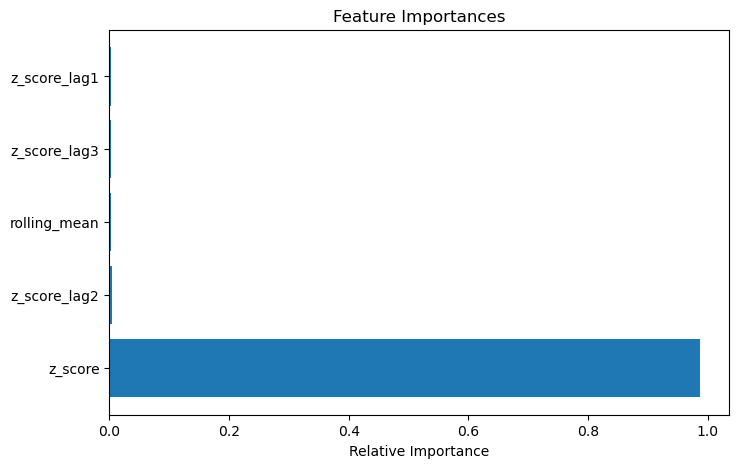

[0.00259074 0.00301197 0.00337439 0.00452863 0.9864943 ]


In [39]:
def feature_importance(Model,feature_df):

    fi = Model.feature_importances_
    feat_names = feature_df.columns

    # Create a sorted bar chart
    indices = np.argsort(fi)[::-1]
    plt.figure(figsize=(8,5))
    plt.barh(feat_names[indices], fi[indices])
    plt.title("Feature Importances")
    plt.xlabel("Relative Importance")
    plt.show()

    print(np.sort(fi))

feature_importance(best_model,train_x)

In [40]:
threshold_long = 0.6
threshold_short = 0.6
hold_period    = 5
initial_capital = 100  # per pair



In [41]:
import numpy as np

# ─────────────────────────────────────────────────────────────────────────────
# 0) PARAMETERS
hold_period     = 5      # how many days to hold any new +1/–1 signal
initial_capital = 100    # dollars per pair
# ─────────────────────────────────────────────────────────────────────────────

# 1) RAW MODEL SIGNAL
# ------------------------------------------------------------------
# best_model.predict returns array of {0,1,2} per your label_map:
#   0 ↔ original label -1 (short), 1 ↔ 0 (no‐trade), 2 ↔ 1 (long)
inv_map = {v:k for k,v in label_map.items()}  
raw_codes = best_model.predict(test_x)
# assign by position so we avoid any index errors:
test_spread_long['signal_raw'] = np.vectorize(inv_map.get)(raw_codes)



/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_24148/97206915.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_spread_long['signal_raw'] = np.vectorize(inv_map.get)(raw_codes)


In [42]:

# 2) HOLDING WINDOW
# ------------------------------------------------------------------
# Once you get a +1 or -1, forward‐fill it for `hold_period` days, per pair
test_spread_long['signal'] = (
    test_spread_long
      .groupby('pair')['signal_raw']
      .transform(lambda s: s.replace(0, np.nan).ffill(limit=hold_period))
      .fillna(0)
      .astype(int)
)

test_spread_long['spread_ret'] = (
    test_spread_long
      .groupby('pair')['spread']
      .transform(lambda x: x.pct_change().shift(-1))
)

test_spread_long

# t2 = test_spread_long.groupby('pair')['signal_raw'].apply(lambda s: s.replace(0, np.nan).ffill(limit=hold_period)).fillna(0).astype(int)

# t2

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_24148/1546794504.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_spread_long['signal'] = (
/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_24148/1546794504.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_spread_long['spread_ret'] = (


,Date,pair,spread,rolling_mean,rolling_std,z_score,rolling_volatility,label,z_score_lag1,spread_lag1,z_score_lag2,spread_lag2,z_score_lag3,spread_lag3,pair_encoded,signal_raw,signal,spread_ret
1200,2020-01-02,ARKK-ARKW,5.941557,7.061693,0.381742,-2.934273,1.266781,1,-1.665181,6.432586,-1.952835,6.271109,-0.692021,6.728982,0,1,1,-0.028357
1201,2020-01-03,ARKK-ARKW,5.773074,7.026575,0.446996,-2.804281,1.383472,1,-2.934273,5.941557,-1.665181,6.432586,-1.952835,6.271109,0,1,1,-0.019282
1202,2020-01-06,ARKK-ARKW,5.661758,6.984499,0.511706,-2.584962,1.461823,1,-2.804281,5.773074,-2.934273,5.941557,-1.665181,6.432586,0,1,1,0.004202
1203,2020-01-07,ARKK-ARKW,5.685550,6.952461,0.561273,-2.257208,1.520195,1,-2.584962,5.661758,-2.804281,5.773074,-2.934273,5.941557,0,1,1,0.076464
1204,2020-01-08,ARKK-ARKW,6.120291,6.933531,0.579766,-1.402704,1.528859,0,-2.257208,5.685550,-2.584962,5.661758,-2.804281,5.773074,0,0,1,-0.025083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12280,2024-12-23,TLT-SPTL,-7.425734,-7.289580,0.092690,-1.468925,0.973043,0,-1.459560,-7.415001,-2.286924,-7.477813,0.107226,-7.258469,4,0,1,-0.010471
12281,2024-12-24,TLT-SPTL,-7.347983,-7.295510,0.090445,-0.580166,0.932532,0,-1.468925,-7.425734,-1.459560,-7.415001,-2.286924,-7.477813,4,0,1,0.006661
12282,2024-12-26,TLT-SPTL,-7.396925,-7.303113,0.089004,-1.054024,0.895354,0,-0.580166,-7.347983,-1.468925,-7.425734,-1.459560,-7.415001,4,0,1,-0.005656
12283,2024-12-27,TLT-SPTL,-7.355086,-7.302660,0.088692,-0.591096,0.889785,0,-1.054024,-7.396925,-0.580166,-7.347983,-1.468925,-7.425734,4,0,1,0.018015


In [43]:
# # 3) NEXT-DAY SPREAD RETURN
# # ------------------------------------------------------------------
# # % change in your spread from t → t+1
# test_spread_long['spread_ret'] = (
#     test_spread_long['spread']
#       .pct_change()
#       .shift(-1)
# )



# # 4) DOLLAR P&L ON THE SPREAD
# # ------------------------------------------------------------------
# # Invest +$100 when signal=+1, –$100 when signal=–1
# test_spread_long['dollar_pnl'] = (
#     test_spread_long['signal'] * 
#     test_spread_long['spread_ret'] * 
#     initial_capital
# )
# 3) NEXT-DAY SPREAD DIFF (not pct-change)
test_spread_long['spread_diff'] = (
    test_spread_long['spread']
      .diff()      # spread_t – spread_{t-1}
      .shift(-1)   # align so that today’s signal applies to tomorrow’s move
)

# 4) DOLLAR P&L ON THE SPREAD (raw-change version)
# --------------------------------------------------------
# We want $100 notional per pair in the spread itself.
# That means we buy (or short) N = 100 / spread_t units of the spread.
# Then PnL = signal * (spread_{t+1} - spread_t) * N

test_spread_long['adjusted_spread'] = np.where(np.abs(test_spread_long['spread']) < 1,
                                 np.sign(test_spread_long['spread']) * 1,
                                 test_spread_long['spread'])

test_spread_long['position_size'] = initial_capital / test_spread_long['adjusted_spread']
test_spread_long['dollar_pnl'] = (
    test_spread_long['signal'] *
    test_spread_long['spread_diff'] *
    test_spread_long['position_size']
)



# test_spread_long['spread_diff'] = (
#     test_spread_long['spread'].diff().shift(-1)
# )

# test_spread_long['posi']

/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_24148/1639980662.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_spread_long['spread_diff'] = (
/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_24148/1639980662.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_spread_long['adjusted_spread'] = np.where(np.abs(test_spread_long['spread']) < 1,
/var/folders/qd/xclxh05s0x9509nblm6z434w0000gp/T/ipykernel_24148/1639980662.py:37: SettingWithCopyWarning: 
A value is trying to be

In [44]:
subset = test_spread_long[test_spread_long['pair']=='ARKK-ARKW']

subset = subset[subset['Date'] > '2021-11-23']
subset = subset[subset['Date'] < '2021-11-30']


print(subset[['Date','spread']].tail(5))

print(test_spread_long['spread'].describe())


           Date    spread
1679 2021-11-24  0.609024
1680 2021-11-26  0.679258
1681 2021-11-29 -0.190090
count    6285.000000
mean      -17.456595
std        35.150662
min      -164.145062
25%        -7.088107
50%        -3.195993
75%         3.807404
max        25.168741
Name: spread, dtype: float64


In [45]:
def build_test_features(spread_long_df, pair_name, features, train_cutoff):
    # Filter for pair and test period
    df = spread_long_df[(spread_long_df['pair'] == pair_name) & (spread_long_df['Date'] >= train_cutoff)].copy()
    df.set_index('Date', inplace=True)
    X_test = df[features]
    return X_test, df  # return also the full df to get z_score and prices

def build_prices_for_pair(pair_name, prices_df, test_index):
    etf1, etf2 = pair_name.split('-')
    price_df = prices_df[[etf1, etf2]].loc[test_index].copy()
    price_df.columns = ['price_long', 'price_short']
    return price_df

def simulate_portfolio(X_test, probs, y_pred_label, prices_df,
                       initial_cash_per_pair=100.0, holding_period=5, entry_threshold=0.2):
    equity = pd.Series(index=X_test.index, dtype=float)
    equity.iloc[0] = initial_cash_per_pair
    trades = []

    for i in range(len(X_test) - holding_period):
        prob_long = probs[i][2]  # probability of long
        prob_short = probs[i][0] # probability of short
        zscore = X_test['z_score'].iloc[i] if 'z_score' in X_test.columns else 0

        signal = 0
        if prob_long > entry_threshold and zscore < -1.5:
            signal = 1
        elif prob_short > entry_threshold and zscore > 1.5:
            signal = -1

        if signal != 0:
            entry_idx = i
            exit_idx = i + holding_period
            if exit_idx >= len(X_test):
                break

            price_long_in = prices_df['price_long'].iloc[entry_idx]
            price_short_in = prices_df['price_short'].iloc[entry_idx]

            price_long_out = prices_df['price_long'].iloc[exit_idx]
            price_short_out = prices_df['price_short'].iloc[exit_idx]

            notional = initial_cash_per_pair

            if signal == 1:
                shares_long = notional / 2 / price_long_in
                shares_short = notional / 2 / price_short_in
                pnl = (shares_long * (price_long_out - price_long_in)) + (shares_short * (price_short_in - price_short_out))
                direction = "Long ETF1 / Short ETF2"
            else:
                shares_short = notional / 2 / price_long_in
                shares_long = notional / 2 / price_short_in
                pnl = (shares_long * (price_short_out - price_short_in)) + (shares_short * (price_long_in - price_long_out))
                direction = "Short ETF1 / Long ETF2"

            equity.iloc[exit_idx] = equity.iloc[entry_idx] + pnl
            trades.append({
                "entry_date": X_test.index[entry_idx],
                "exit_date": X_test.index[exit_idx],
                "direction": direction,
                "pnl": pnl,
                "notional": notional,
                "prob_long": prob_long,
                "prob_short": prob_short,
                "z_score": zscore
            })

    equity.ffill(inplace=True)
    return equity, trades

# Now run for all pairs
def run_full_simulation(spread_long, prices, pairs, best_model, features, train_cutoff,
                        initial_cash_per_pair=100, holding_period=5, entry_threshold=0.6):
    total_cash = 0
    combined_equity = pd.Series(dtype=float)
    pair_trade_counts = {}
    pair_pnls = {}
    pair_sharpes = {}

    plt.figure(figsize=(14, 6))

    for pair in pairs:
        X_test, df_pair = build_test_features(spread_long, pair, features, train_cutoff)
        prices_df = build_prices_for_pair(pair, prices, X_test.index)

        probs = best_model.predict_proba(X_test)
        y_pred = best_model.predict(X_test)

        equity, trades = simulate_portfolio(X_test, probs, y_pred, prices_df,
                                            initial_cash_per_pair=initial_cash_per_pair,
                                            holding_period=holding_period,
                                            entry_threshold=entry_threshold)

        returns = equity.pct_change().dropna()
        sharpe = (returns.mean() / returns.std()) * np.sqrt(252) if returns.std() != 0 else np.nan

        pair_sharpes[pair] = sharpe
        total_cash += equity.iloc[-1]
        pair_trade_counts[pair] = len(trades)
        pair_pnls[pair] = [t['pnl'] for t in trades]

        if combined_equity.empty:
            combined_equity = equity
        else:
            combined_equity = combined_equity.add(equity, fill_value=0)

        sns.lineplot(x=equity.index, y=equity.values, label=pair)

    plt.title("Equity Curve by Pair")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value ($)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"\nFinal Portfolio Value: ${total_cash:,.2f}")
    print("\nTrade Summary:")
    for pair, count in pair_trade_counts.items():
        total_pnl = sum(pair_pnls[pair])
        avg_pnl = np.mean(pair_pnls[pair]) if pair_pnls[pair] else 0
        print(f"  {pair}: {count} trades | Total PnL: ${total_pnl:.2f} | Avg PnL: ${avg_pnl:.2f}")

    print("\nSharpe Ratios by Pair:")
    for pair, sharpe in pair_sharpes.items():
        print(f"  {pair}: Sharpe Ratio = {sharpe:.2f}")

    combined_returns = combined_equity.pct_change().dropna()
    sharpe_ratio = (combined_returns.mean() / combined_returns.std()) * np.sqrt(252)
    print(f"\nTotal Sharpe Ratio: {sharpe_ratio:.2f}")

    return combined_equity, pair_pnls, pair_trade_counts, pair_sharpes

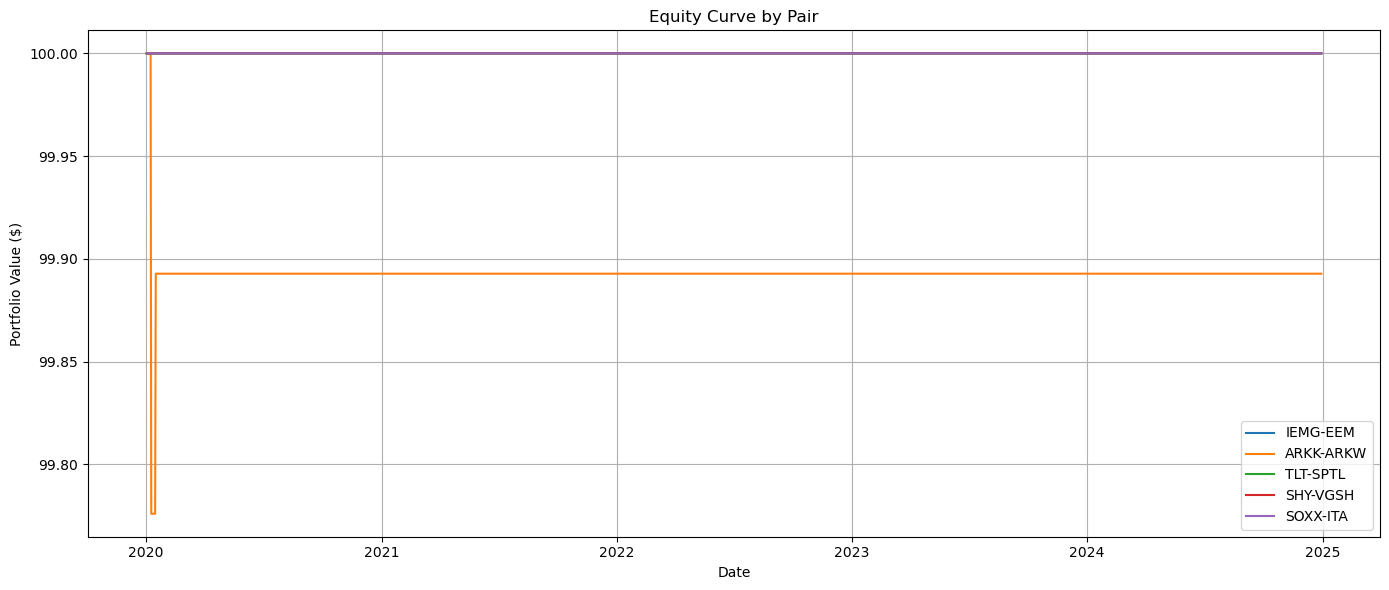


Final Portfolio Value: $499.89

Trade Summary:
  IEMG-EEM: 355 trades | Total PnL: $7.81 | Avg PnL: $0.02
  ARKK-ARKW: 411 trades | Total PnL: $7.41 | Avg PnL: $0.02
  TLT-SPTL: 290 trades | Total PnL: $5.42 | Avg PnL: $0.02
  SHY-VGSH: 225 trades | Total PnL: $3.07 | Avg PnL: $0.01
  SOXX-ITA: 378 trades | Total PnL: $-29.55 | Avg PnL: $-0.08

Sharpe Ratios by Pair:
  IEMG-EEM: Sharpe Ratio = nan
  ARKK-ARKW: Sharpe Ratio = -0.19
  TLT-SPTL: Sharpe Ratio = nan
  SHY-VGSH: Sharpe Ratio = nan
  SOXX-ITA: Sharpe Ratio = nan

Total Sharpe Ratio: -0.19


In [46]:
combined_equity, pair_pnls, trade_counts, sharpe_ratios = run_full_simulation(
    spread_long, 
    prices, 
    pairs, 
    best_model, 
    features, 
    train_cutoff,
    initial_cash_per_pair=100,      # adjust if you want
    holding_period=5,               # adjust if you want
    entry_threshold=0.2             # adjust if you want
)

In [47]:
# # pair = 'ARKK-ARKW'
# # bad_date = '2021-11-26'

# # # isolate just that pair
# # df_pair = test_spread_long[test_spread_long['pair']==pair].copy()

# # # make sure it's sorted by Date
# # df_pair = df_pair.sort_values('Date').set_index('Date')

# # # show spread on the problem date and the following day
# # print(df_pair.loc[bad_date : pd.to_datetime(bad_date) + pd.Timedelta(days=2),
# #                   ['spread', 'spread_ret']])

# pair     = 'ARKK-ARKW'
# bad_date = '2021-11-26'

# # isolate just that pair
# df_pair = test_spread_long[test_spread_long['pair']==pair].copy()

# # make sure it's sorted by Date
# df_pair = df_pair.sort_values('Date').set_index('Date')

# # show spread on the problem date and the following day,
# # but now print spread_diff instead of spread_ret
# print(df_pair.loc[bad_date : pd.to_datetime(bad_date) + pd.Timedelta(days=2),
#                   ['spread', 'spread_diff']])

# # --------------------------------------------------------------------------------------------------
# # OLD sanity check (drop this, it's irrelevant now)
# # if (test_spread_long['spread_ret'] <= -1).any(): ...
# #
# # NEW sanity check: catch any single‐day P&L larger than your initial capital
# max_loss = initial_capital * 2   # e.g. more than 2× your capital is impossible
# if (test_spread_long['dollar_pnl'].abs() > max_loss).any():
#     row = test_spread_long[test_spread_long['dollar_pnl'].abs() > max_loss].iloc[0]
#     raise RuntimeError(f"Insane PnL on {row['Date']} pair={row['pair']}  PnL={row['dollar_pnl']}")

# # 5) PER-PAIR PERFORMANCE  (unchanged)
# def pair_stats(g):
#     daily_pct = (g['dollar_pnl'] / initial_capital).dropna()
#     if len(daily_pct) < 2:
#         return pd.Series({'sharpe': np.nan, 'cum_return': np.nan})
#     sharpe     = (daily_pct.mean() / daily_pct.std()) * np.sqrt(252)
#     cum_return = (1 + daily_pct).prod() - 1
#     return pd.Series({'sharpe': sharpe, 'cum_return': cum_return})

# pair_metrics = test_spread_long.groupby('pair').apply(pair_stats)
# print("\nPer-pair results:")
# print(pair_metrics)

# # 6) AGGREGATE METRICS & EQUITY CURVE  (unchanged)
# daily_pnl = test_spread_long.groupby('Date')['dollar_pnl'].sum()
# n_pairs   = test_spread_long['pair'].nunique()
# total_cap = initial_capital * n_pairs
# daily_pct  = daily_pnl / total_cap

# equity     = (1 + daily_pct).cumprod() * total_cap
# agg_sharpe = (daily_pct.mean() / daily_pct.std()) * np.sqrt(252)
# agg_return = equity.iloc[-1]/total_cap - 1

# print(f"\nAggregate total return:      {agg_return:.2%}")
# print(f"Aggregate annualized Sharpe: {agg_sharpe:.2f}")

# import matplotlib.pyplot as plt
# plt.figure(figsize=(10,5))
# plt.plot(equity.index, equity.values, label='Equity')
# plt.title('Pairs-Trading Equity Curve (Spread Only)')
# plt.xlabel('Date')
# plt.ylabel('Portfolio Value')
# plt.legend()
# plt.show()



In [48]:
# except Exception as e:
#     print("❗ Failed assigning signal")
#     print("df.shape =", df.shape)
#     print("df.index[:5] =", df.index[:5])
#     print("series.shape =", some_series.shape)
#     print("series.index[:5] =", some_series.index[:5])
#     raise